Descargando desde: https://portal.opentopography.org/API/globaldem?demtype=SRTMGL1&west=-74.85&south=10.92&east=-74.75&north=11&outputFormat=GTiff&API_Key=62cac756f35733aeebec31ea0b1516cd
Archivo guardado: Barranquilla_DEM.tif


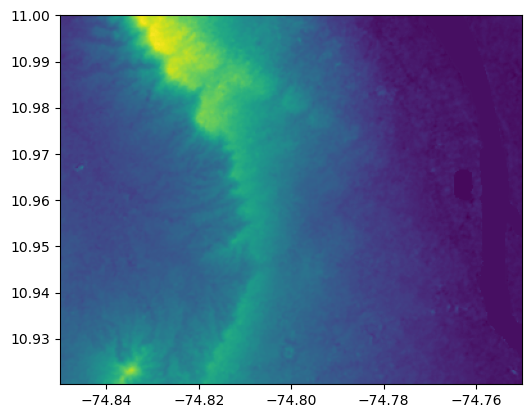

In [5]:
import os
import requests
import rasterio as rio
from rasterio.plot import show

# Definir las coordenadas del área de interés y el tipo de DEM
bounds = (-74.85, 10.92, -74.75, 11)  # Coordenadas para Barranquilla en crs 4326 (Oeste, Sur, Este, Norte)
demtype = "SRTMGL1"  # Tipo de DEM: "SRTMGL3", "AW3D30", etc.

# URL base de la API de OpenTopography
base_url = "https://portal.opentopography.org/API/globaldem?demtype={}&west={}&south={}&east={}&north={}&outputFormat=GTiff&API_Key={}"

# Tu clave de API
api_key = "aquivatuclavedeapientrecomillasporsupuestovisitalapaginadeopentopoparaobtenerla"

# Función para descargar el DEM
def get_ot_globaldem(demtype, bounds, out_fn=None):
    if out_fn is None:
        out_fn = f"{demtype}_DEM.tif"  # Nombre predeterminado si no se proporciona
    if not os.path.exists(out_fn):
        url = base_url.format(demtype, *bounds, api_key)
        print(f"Descargando desde: {url}")
        response = requests.get(url)
        if response.status_code == 200:
            with open(out_fn, 'wb') as f:
                f.write(response.content)
            print(f"Archivo guardado: {out_fn}")
        else:
            print(f"Error en la descarga. Código de estado: {response.status_code}")
            print(f"Mensaje de error: {response.text}")
            return None
    return out_fn

# Puedes especificar el nombre del archivo aquí
output_file_name = "Barranquilla_DEM.tif" 

# Descargar el DEM
output_file = get_ot_globaldem(demtype, bounds, out_fn=output_file_name)

# Verificar si el archivo fue descargado correctamente
if output_file is None or not os.path.exists(output_file):
    raise FileNotFoundError("El archivo DEM no pudo ser descargado. Verifica los parámetros o la clave API.")

# Visualizar el DEM
with rio.open(output_file) as src:
    show(src)


Leyendo el raster...
Estadísticas del raster: Min=-5.0, Max=145.0
Generando coordenadas...
Generando curvas de nivel...
Extrayendo geometrías de las curvas...


C:\Users\Janus\AppData\Local\Temp\ipykernel_1812\580987362.py:67: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for level, collection in zip(contour_set.levels, contour_set.collections):


Creando GeoDataFrame...
Guardando curvas de nivel en C:\Users\Janus\Downloads\curvas_de_nivel_Barranquilla.shp...
Proceso completado.


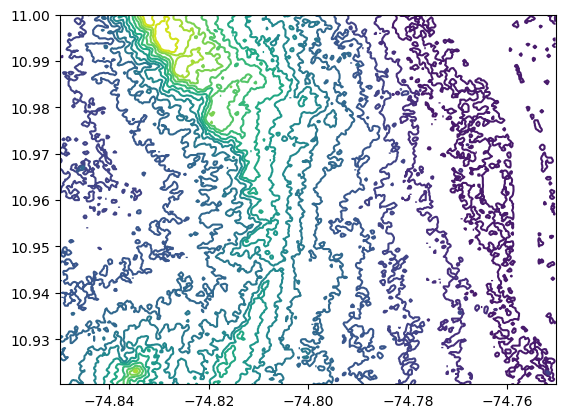

In [9]:
import os
import numpy as np
import rasterio
from shapely.geometry import LineString
import geopandas as gpd
import matplotlib.pyplot as plt

# Ruta del archivo raster y gdf de salida
raster_path = r"C:\Users\Janus\Downloads\Barranquilla_DEM.tif"
output_path = r"C:\Users\Janus\Downloads\curvas_de_nivel_Barranquilla.shp"

# Parámetros para las curvas de nivel
contour_interval = 10

# Leer el archivo raster
print("Leyendo el raster...")
with rasterio.open(raster_path) as src:
    raster_data = src.read(1)  # Leer la banda de elevación
    transform = src.transform  # Transformación para coordenadas
    nodata = src.nodata  # Valor nodata del raster
    crs = src.crs  # Sistema de coordenadas
    
    # Reemplazar valores nodata por NaN
    if nodata is not None:
        raster_data = np.where(raster_data == nodata, np.nan, raster_data)

# Verificar estadísticas
min_elev = np.nanmin(raster_data)
max_elev = np.nanmax(raster_data)
print(f"Estadísticas del raster: Min={min_elev}, Max={max_elev}")

# Crear una cuadrícula de coordenadas
print("Generando coordenadas...")
height, width = raster_data.shape
x_coords = np.arange(width)
y_coords = np.arange(height)
x_world, y_world = np.meshgrid(
    np.linspace(0, width - 1, width),
    np.linspace(0, height - 1, height)
)
x_world, y_world = rasterio.transform.xy(transform, y_world, x_world, offset="center")
x_world = np.array(x_world)
y_world = np.array(y_world)

# Generar los contornos con matplotlib
print("Generando curvas de nivel...")
levels = np.arange(min_elev, max_elev + contour_interval, contour_interval)
contour_set = plt.contour(x_world, y_world, raster_data, levels=levels)

# Extraer las curvas como geometrías con sus elevaciones
print("Extrayendo geometrías de las curvas...")
contour_lines = []
contour_elevations = []

# Límites del cuadro (calculando las coordenadas de las esquinas)
xmin, ymin = rasterio.transform.xy(transform, 0, 0)  # Esquina inferior izquierda
xmax, ymax = rasterio.transform.xy(transform, height-1, width-1)  # Esquina superior derecha

# Función para verificar intersección con líneas anteriores
def check_intersection(new_line, existing_lines):
    for line in existing_lines:
        if new_line.intersects(line):
            return True  # Si intersecta con alguna línea, devolver True
    return False  # Si no intersecta con ninguna, devolver False

# Iterar sobre los contornos y extraer los niveles de elevación
for level, collection in zip(contour_set.levels, contour_set.collections):
    for path in collection.get_paths():
        for coords in path.to_polygons():
            if len(coords) > 1:  # Evitar geometrías vacías
                coords_array = np.array(coords)  # Convertir a un array de numpy

                # Verificar si la línea cruza los bordes
                if (
                    np.any(coords_array[:, 0] == xmin) or
                    np.any(coords_array[:, 0] == xmax) or
                    np.any(coords_array[:, 1] == ymin) or
                    np.any(coords_array[:, 1] == ymax)
                ):
                    # Mantener la línea abierta en los bordes
                    line = LineString(coords_array[:-1])  # Eliminamos el último punto (en el borde)
                else:
                    line = LineString(coords_array)

                # Verificar intersección con líneas anteriores
                if not check_intersection(line, contour_lines):
                    contour_lines.append(line)
                    contour_elevations.append(level)  # Asociar el nivel actual a la geometría

# Crear un GeoDataFrame con las curvas de nivel
print("Creando GeoDataFrame...")
gdf = gpd.GeoDataFrame(
    {'elevation': contour_elevations, 'geometry': contour_lines},
    crs=crs.to_wkt()
)

# Exportar el GeoDataFrame como shapefile
print(f"Guardando curvas de nivel en {output_path}...")
gdf.to_file(output_path, driver="ESRI Shapefile")
print("Proceso completado.")


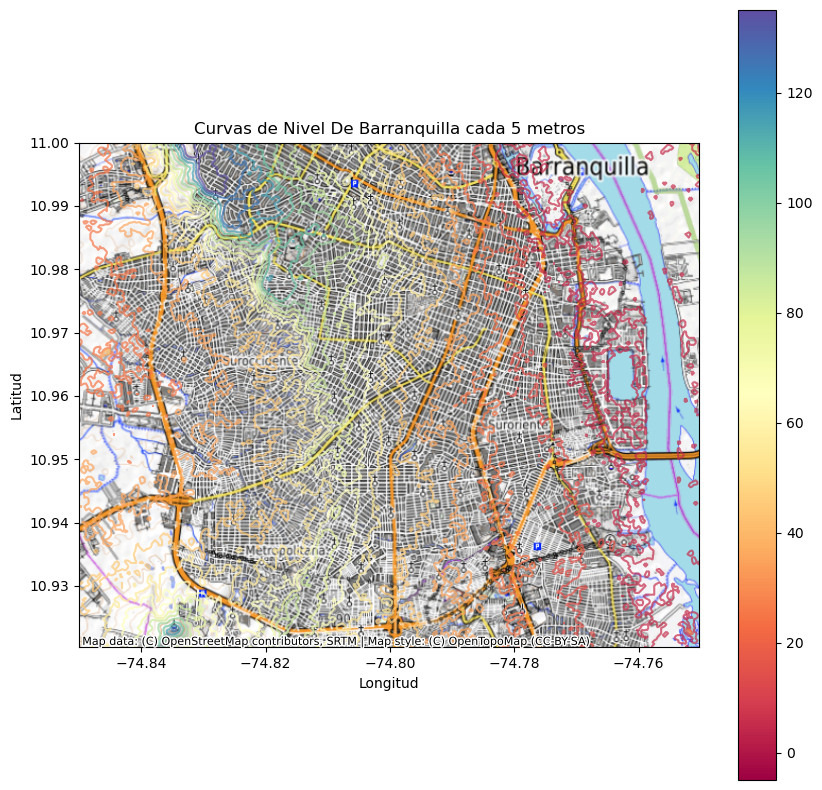

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx  # Asegúrate de importar contextily

# Asumimos que 'gdf_curves' ya está definido y contiene tus curvas de nivel
fig, ax = plt.subplots(figsize=(10, 10))

# Graficar las curvas de nivel con un cmap basado en la elevación
# Asumiendo que 'elevation' es la columna que contiene los valores de elevación
gdf.plot(ax=ax, column='elevation', cmap='Spectral', legend=True, alpha=0.7)

# Agregar el mapa base usando contextily
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenTopoMap)

# Establecer los límites del gráfico según las dimensiones del gdf
minx, miny, maxx, maxy = gdf.total_bounds  # Obtener los límites del gdf
ax.set_xlim(minx, maxx)  # Establecer los límites en X
ax.set_ylim(miny, maxy)  # Establecer los límites en Y

# Establecer título y etiquetas
ax.set_title("Curvas de Nivel De Barranquilla cada 5 metros")
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")

plt.show()


In [4]:
gdf

,elevation,geometry
0,1432.0,"LINESTRING (-75.56889 6.28417, -75.56889 6.284..."
1,1482.0,"LINESTRING (-75.56040 6.30000, -75.56039 6.299..."
2,1482.0,"LINESTRING (-75.56694 6.28311, -75.56667 6.283..."
3,1482.0,"LINESTRING (-75.57778 6.27477, -75.57782 6.274..."
4,1482.0,"LINESTRING (-75.57917 6.27306, -75.57917 6.273..."
...,...,...
1114,2832.0,"LINESTRING (-75.56778 6.10250, -75.56778 6.102..."
1115,2882.0,"LINESTRING (-75.56722 6.10819, -75.56694 6.108..."
1116,2882.0,"LINESTRING (-75.55000 6.10781, -75.54972 6.107..."
1117,2882.0,"LINESTRING (-75.56639 6.10704, -75.56611 6.107..."


In [13]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.transform import from_bounds
from rasterio.features import rasterize
from scipy.interpolate import griddata
from shapely.geometry import Point

# Definir el método de interpolación (puedes cambiar este valor entre 'linear', 'cubic', o 'nearest')
interpolation_method = 'cubic'  # Cambia a 'linear' o 'nearest' según sea necesario

# Verificar que el GeoDataFrame no esté vacío y tenga una columna 'cota'
if gdf.empty:
    raise ValueError("El GeoDataFrame está vacío.")
if 'elevation' not in gdf.columns:
    raise ValueError("El GeoDataFrame debe contener la columna 'elevation'.")

# Transformar a CRS proyectado en este caso Magna Sirgas Origen Nacional (EPSG:9377) o al de tu zona
gdf = gdf.to_crs(epsg=9377)
if not gdf.crs.is_projected:
    raise ValueError("El CRS debe estar proyectado (como UTM).")

# Convertir geometrías MULTILINESTRING a puntos
points = []
cotas = []

for _, row in gdf.iterrows():
    geom = row['geometry']
    cota = row['elevation']
    
    if geom.geom_type == 'MultiLineString':
        for subline in geom.geoms:
            for x, y in subline.coords:
                points.append(Point(x, y))
                cotas.append(cota)
    elif geom.geom_type == 'LineString':
        for x, y in geom.coords:
            points.append(Point(x, y))
            cotas.append(cota)

# Crear un nuevo GeoDataFrame con los puntos
gdf_points = gpd.GeoDataFrame({'geometry': points, 'elevation': cotas}, crs=gdf.crs)

# Calcular el bounding box y la resolución
minx, miny, maxx, maxy = gdf_points.total_bounds
resolution = 1  # Tamaño del píxel (metros)
width = int((maxx - minx) / resolution)
height = int((maxy - miny) / resolution)

# Validar las dimensiones del ráster
if width <= 0 or height <= 0:
    raise ValueError(f"Dimensiones del ráster inválidas: width={width}, height={height}")

# Crear la transformación affine
transform = from_bounds(minx, miny, maxx, maxy, width, height)

# Rasterizar las curvas de nivel con los valores de 'COTA_M'
shapes = ((geom, value) for geom, value in zip(gdf_points.geometry, gdf_points['elevation']))
raster = rasterize(
    shapes=shapes,
    out_shape=(height, width),
    transform=transform,
    fill=-9999,
    dtype='float64'
)

# Validar que el ráster tenga datos válidos
if np.all(raster == -9999):
    raise ValueError("El ráster está vacío. Verifique los datos de entrada.")

# Crear una malla de coordenadas para la interpolación
y_coords, x_coords = np.mgrid[miny:maxy:complex(height), minx:maxx:complex(width)]

# Invertir el eje Y (sur/norte) para que se alinee correctamente
y_coords = np.flipud(y_coords)  # Invertir la dirección del eje Y

xi = np.column_stack((x_coords.flatten(), y_coords.flatten()))

# Extraer posiciones de las celdas con datos y sus valores
mask = raster != -9999
positions = np.column_stack(np.where(mask))
values = raster[mask]

# Ajustar posiciones a coordenadas del ráster
positions_converted = np.array([ 
    [transform[2] + transform[0] * x, transform[5] + transform[4] * y] 
    for y, x in positions 
])

# Validar que el método de interpolación sea uno de los permitidos
if interpolation_method not in ['linear', 'cubic', 'nearest']:
    raise ValueError("Método de interpolación no válido. Debe ser 'linear', 'cubic', o 'nearest'.")

# Realizar la interpolación según el método elegido
try:
    interpolated = griddata(
        points=positions_converted,
        values=values,
        xi=xi,
        method=interpolation_method,
        fill_value=-9999
    )
except Exception as e:
    print(f"Error en la interpolación: {e}. Verifique los datos de entrada.")

# Validar la interpolación
if interpolated is None or np.all(interpolated == -9999):
    raise ValueError("La interpolación no produjo resultados válidos. Verifique los datos de entrada.")

# Reajustar la interpolación a la forma del ráster
interpolated = interpolated.reshape(height, width)

# Guardar el ráster interpolado en un archivo GeoTIFF
output_path = f"curvas_de_nivel_interpolada_b{interpolation_method}.tif"
with rasterio.open(
    output_path,
    'w',
    driver='GTiff',
    height=interpolated.shape[0],
    width=interpolated.shape[1],
    count=1,
    dtype='float64',
    crs=gdf.crs,
    transform=transform,
    nodata=-9999
) as dst:
    dst.write(interpolated, 1)

print(f"Ráster interpolado guardado en {output_path}")


Ráster interpolado guardado en curvas_de_nivel_interpolada_bcubic.tif


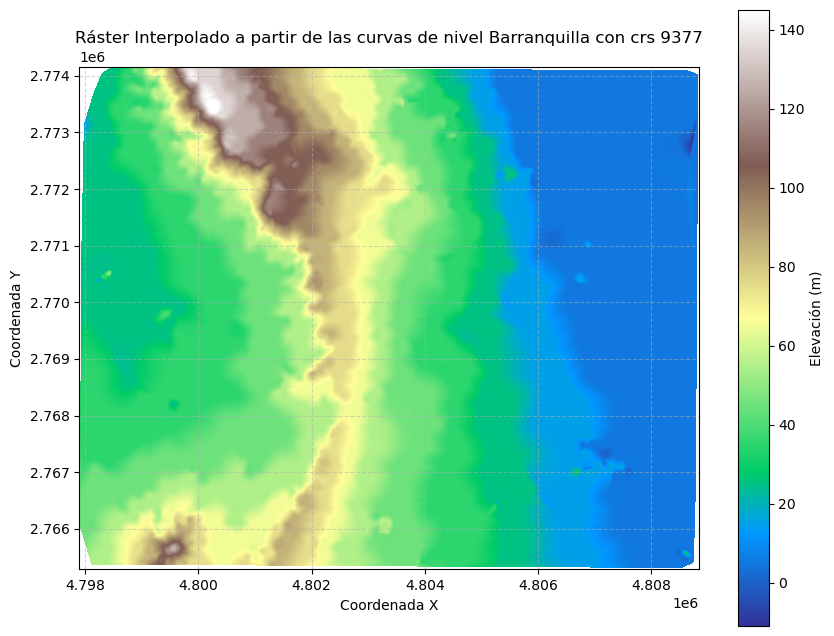

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio

with rasterio.open(r"C:\Users\Janus\Downloads\curvas_de_nivel_interpolada_bcubic.tif") as src:
    raster = src.read(1)
    transform = src.transform  
    crs = src.crs  

# Convertir el raster a un tipo flotante para manejar NaN si es necesario
raster = raster.astype(np.float64)  # Cambiar el tipo de datos a flotante

# Reemplazar los valores -9999 (nodata) por NaN
raster[raster == -9999] = np.nan

# Graficar el raster
plt.figure(figsize=(10, 8))
plt.imshow(raster, cmap='terrain', extent=(transform[2], 
                                           transform[2] + raster.shape[1] * transform[0], 
                                           transform[5] + raster.shape[0] * transform[4], 
                                           transform[5]),
           origin="upper", vmin=np.nanmin(raster), vmax=145)  # Establecer límite máximo en 145
plt.colorbar(label="Elevación (m)")
plt.title("Ráster Interpolado a partir de las curvas de nivel Barranquilla con crs 9377")
plt.xlabel("Coordenada X")
plt.ylabel("Coordenada Y")
plt.grid(visible=True, linestyle="--", alpha=0.5)
plt.show()


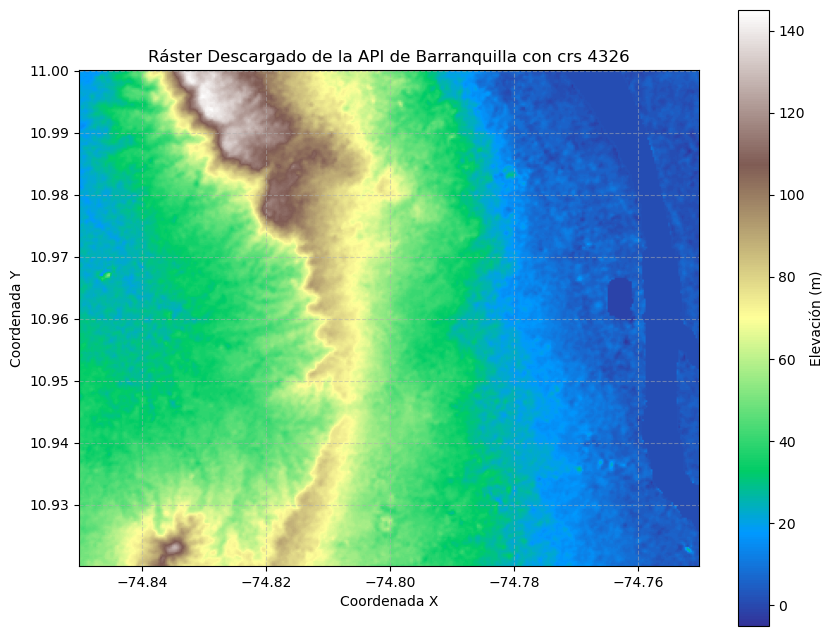

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio

# Abrir el archivo raster
with rasterio.open(r"C:\Users\Janus\Downloads\Barranquilla_DEM.tif") as src:
    raster = src.read(1)  # Leer la primera banda del raster
    transform = src.transform  # Obtener la transformación
    crs = src.crs  # Obtener el sistema de referencia de coordenadas

# Convertir el raster a un tipo flotante para manejar NaN
raster = raster.astype(np.float64)  # Cambiar el tipo de datos a flotante

# Reemplazar los valores -9999 (nodata) por NaN
raster[raster == -9999] = np.nan

# Graficar el raster
plt.figure(figsize=(10, 8))
plt.imshow(raster, cmap='terrain', extent=(transform[2], 
                                           transform[2] + raster.shape[1] * transform[0], 
                                           transform[5] + raster.shape[0] * transform[4], 
                                           transform[5]),
           origin="upper")
plt.colorbar(label="Elevación (m)")
plt.title("Ráster Descargado de la API de Barranquilla con crs 4326")
plt.xlabel("Coordenada X")
plt.ylabel("Coordenada Y")
plt.grid(visible=True, linestyle="--", alpha=0.5)
plt.show()
